In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import os
# Any results you write to the current directory are saved as output.

/kaggle/input/scene-classification/test_WyRytb0.csv
/kaggle/input/scene-classification/train-scene classification/train.csv
/kaggle/input/scene-classification/train-scene classification/train/15879.jpg
/kaggle/input/scene-classification/train-scene classification/train/23984.jpg
/kaggle/input/scene-classification/train-scene classification/train/15373.jpg
/kaggle/input/scene-classification/train-scene classification/train/15018.jpg
/kaggle/input/scene-classification/train-scene classification/train/2562.jpg
/kaggle/input/scene-classification/train-scene classification/train/22458.jpg
/kaggle/input/scene-classification/train-scene classification/train/11848.jpg
/kaggle/input/scene-classification/train-scene classification/train/2864.jpg
/kaggle/input/scene-classification/train-scene classification/train/1441.jpg
/kaggle/input/scene-classification/train-scene classification/train/11107.jpg
/kaggle/input/scene-classification/train-scene classification/train/7320.jpg
/kaggle/input/scene-cl

# Data preprocessing

In [2]:
import random 
import cv2, os
import seaborn as sns

In [3]:
#Load datasets
#datatypes
###'buildings' -> 0,     'forest' -> 1,     'glacier' -> 2,     'mountain' -> 3,     'sea' -> 4,     'street' -> 5
train_data = pd.read_csv('../input/scene-classification/train-scene classification/train.csv', delimiter=',')
test_data = pd.read_csv('../input/scene-classification/test_WyRytb0.csv', delimiter=',')
train_data.shape, test_data.shape

((17034, 2), (7301, 1))

In [4]:
#data visulaization
train_data.head(), 
test_data.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8e3d36550>]],
      dtype=object)

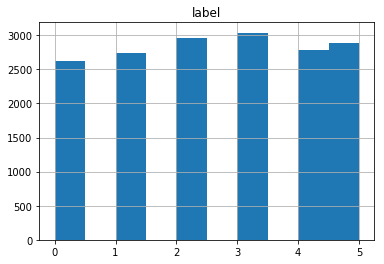

In [5]:
train_data.hist()

In [6]:
train_x, train_y = train_data['image_name'], train_data['label']
train_x.shape, train_y.shape

((17034,), (17034,))

In [7]:
#soring the data in 
train_X, train_Y = [],[]
for ind, entry in enumerate(train_x):
#     if ind>=10000:
#         break
    img = cv2.imread('../input/scene-classification/train-scene classification/train/'+entry)
    if img.shape[0]<150 or img.shape[1]<150:
        img = cv2.resize(img,(150, 150))
        #print("skip", entry)
        #continue
    train_X.append(img)
    train_Y.append(train_y[ind])
    
train_X, train_Y = np.asarray(train_X), np.asarray(train_Y)    
train_X.shape, train_Y.shape

((17034, 150, 150, 3), (17034,))

In [8]:
#soring the data in 
real_test_X = []
for ind, entry in enumerate(test_data['image_name']):
#     if ind>=5000:
#         break
    img = cv2.imread('../input/scene-classification/train-scene classification/train/'+entry)
    if img.shape[0]<150 or img.shape[1]<150 or img.shape[0]>150 or img.shape[1]>150:
        img = cv2.resize(img,(150, 150))
        #print("skip", entry)
        #continue
    real_test_X.append(img)
    
real_test_X = np.asarray(real_test_X)
real_test_X = real_test_X.reshape(-1, 150, 150, 3)#/255
real_test_X.shape

(7301, 150, 150, 3)

In [9]:
#one hot encoding of labels
from keras.utils.np_utils import to_categorical
train_X = train_X.reshape(-1, 150, 150, 3)

train_Y = to_categorical(train_Y)
num_classes = train_Y.shape[1]
num_classes, train_X.shape, train_Y.shape

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

(6, (17034, 150, 150, 3), (17034, 6))

In [10]:
seed = 43
np.random.seed(seed)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=.20, random_state=40, stratify = train_Y )
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((13627, 150, 150, 3), (13627, 6), (3407, 150, 150, 3), (3407, 6))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.10, random_state=7, stratify = y_train)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12264, 150, 150, 3), (12264, 6), (1363, 150, 150, 3), (1363, 6))

# Initializing inbuilt inception model

In [13]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input

In [14]:
#defining pre define model
input_tensor = Input(shape=(150, 150, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 2s 0us/step


In [15]:
X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(1024, activation='relu')(X)

final_layer = Dense(num_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=final_layer)

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, shuffle=True)

Train on 12264 samples, validate on 3407 samples
Epoch 1/100
12264/12264 [==============================] - 48s 4ms/step - loss: 1.6872 - acc: 0.3657 - val_loss: 7.4521 - val_acc: 0.3819
Epoch 2/100
12264/12264 [==============================] - 28s 2ms/step - loss: 0.5915 - acc: 0.7930 - val_loss: 4.2243 - val_acc: 0.4303
Epoch 3/100
12264/12264 [==============================] - 28s 2ms/step - loss: 0.4041 - acc: 0.8683 - val_loss: 10.7958 - val_acc: 0.3017
Epoch 4/100
12264/12264 [==============================] - 28s 2ms/step - loss: 0.3019 - acc: 0.8995 - val_loss: 1.5909 - val_acc: 0.7065
Epoch 5/100
12264/12264 [==============================] - 28s 2ms/step - loss: 0.2270 - acc: 0.9256 - val_loss: 0.5148 - val_acc: 0.8488
Epoch 6/100
12264/12264 [==============================] - 28s 2ms/step - loss: 0.2081 - acc: 0.9362 - val_loss: 3.1603 - val_acc: 0.6551
Epoch 7/100
12264/12264 [==============================] - 28s 2ms/step - loss: 0.1355 - acc: 0.9560 - val_loss: 0.8509 - 

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0]) #Test loss: 1.1092
print('Test accuracy:', score[1]) #Test accuracy: 0.7842993397793172

1363/1363 [==============================] - 2s 1ms/step
Test loss: 0.6558700980275585
Test accuracy: 0.8862802642107185


In [18]:
import h5py
model.save('my_resnet50_model.h5')

from keras.models import load_model

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model(r'kaggle/working/my_model.h5')

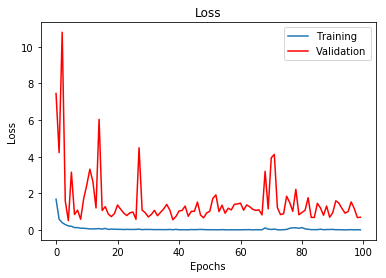

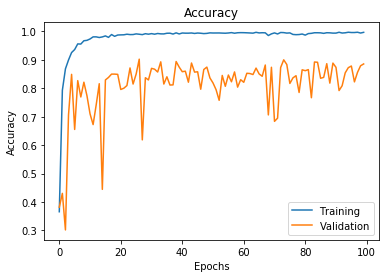

In [19]:
import matplotlib.pyplot as plt
def draw_model(training):

    plt.plot(training.history['loss'])

    plt.plot(training.history['val_loss'],'r')

    plt.xlabel("Epochs")

    plt.ylabel("Loss")

    plt.title("Loss")

    plt.legend(["Training","Validation"])

    plt.show()

    plt.plot(training.history['acc'])

    plt.plot(training.history['val_acc'])

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.title("Accuracy")

    plt.legend(["Training","Validation"],loc=4)

    plt.show()

   

draw_model(history)

In [20]:
y_pred = model.predict(x_test)
y_pred.shape

(1363, 6)

In [21]:
from sklearn.metrics import confusion_matrix
#'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[196,   1,   1,   1,   4,   7],
       [  0, 211,   2,   2,   3,   1],
       [  1,   0, 203,  24,   9,   0],
       [  0,   0,  49, 185,   9,   0],
       [  1,   0,   2,   4, 216,   0],
       [ 21,   3,   3,   1,   6, 197]])

In [22]:
# # AUC Curve
# from sklearn import metrics
# fpr, tpr, _ = metrics.roc_curve(y_test.argmax(axis=1),   y_pred.argmax(axis=1))
# auc = metrics.roc_auc_score(y_test.argmax(axis=1),   y_pred.argmax(axis=1))
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

In [23]:
test_data.head(5), real_test_X.shape

(  image_name
 0      3.jpg
 1      5.jpg
 2      6.jpg
 3     11.jpg
 4     14.jpg, (7301, 150, 150, 3))

In [24]:
scene_dict = {0:'buildings', 1:'forest', 2:'glacier', 3:'mountain' ,4:'sea', 5:'street'}
pred_real_data = model.predict(real_test_X)
pred_real_data.shape

(7301, 6)

In [25]:
pred_res = []
for i in pred_real_data.argmax(axis=1):
    pred_res.append(scene_dict[i])
len(pred_res)

7301

In [26]:
test_data.insert(1, 'Prediction', pred_res )
test_data.head(5)

,image_name,Prediction
0,3.jpg,street
1,5.jpg,buildings
2,6.jpg,sea
3,11.jpg,glacier
4,14.jpg,street


In [27]:
test_data.to_csv('sample_submission_CH2mq5Z.csv',index=False)

In [28]:
%pwd

'/kaggle/working'

In [29]:
test_data.to_csv('sample_submission_CH2mq5Z.csv',index=False)